# Week 1 - Data Cleaning and EDA
---

In [ ]:
# Our team will be using the Spotify dataset.
# The question we will be exploring is "Can we predict a song's popularity using its musical features?"
# Main features we will be using: track_id, popularity, explicit, danceability, energy, loudness, liveness, tempo, track_genre

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from mlxtend.evaluate import bias_variance_decomp

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 100

df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")

## Data Cleaning

To use the data with full confidence, we cleaned our data. First, we checked for and filled in missing values with corresponding means, medians, and modes.

In [ ]:
# Check for missing values.
print("Missing values before cleaning:\n", df.isnull().sum())
print("\n")

# Drop rows where critical features like track_id or track_name are missing.
df_cleaned = df.dropna(subset=['track_id', 'track_name'])

# Key is a special feature. If a key cannot be determined, the key is assigned a value of -1.
missing_key_count = (df_cleaned['key'] == -1).sum()
print("Number of songs without a key: ", missing_key_count)

# Fill in missing numerical values with their corresponding feature's mean or median.
df_cleaned.loc[:, 'popularity'] = df_cleaned['popularity'].fillna(df_cleaned['popularity'].mean())
df_cleaned.loc[:, 'danceability'] = df_cleaned['danceability'].fillna(df_cleaned['danceability'].median())
df_cleaned.loc[:, 'energy'] = df_cleaned['energy'].fillna(df_cleaned['energy'].mean())
df_cleaned.loc[:, 'loudness'] = df_cleaned['loudness'].fillna(df_cleaned['loudness'].median())
df_cleaned.loc[:, 'liveness'] = df_cleaned['liveness'].fillna(df_cleaned['liveness'].mean())
df_cleaned.loc[:, 'tempo'] = df_cleaned['tempo'].fillna(df_cleaned['tempo'].mean())

# Fill missing categorical values with their corresponding feature's most common value (mode).
df_cleaned.loc[:, 'track_genre'] = df_cleaned['track_genre'].fillna(df_cleaned['track_genre'].mode()[0])
df_cleaned.loc[:, 'explicit'] = df_cleaned['explicit'].fillna(df_cleaned['explicit'].mode()[0])

# Verify that we have no more missing values.
print("\n\nMissing values after cleaning:\n", df_cleaned.isnull().sum())

Missing values before cleaning:
 Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


Number of songs without a key:  0


Missing values after cleaning:
 Unnamed: 0          0
track_id            0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time

Then, we checked for outliers and removed duplicate data for the same track.

In [ ]:
# CHECK FOR OUTLIERS

# Speechiness
outlier_speechiness = df_cleaned[(df_cleaned['speechiness'] < 0) | (df_cleaned['speechiness'] > 1)]
print("Number of outliers in speechiness: ", outlier_speechiness.shape[0])

# Popularity
Q1 = df_cleaned['popularity'].quantile(0.25)
Q3 = df_cleaned['popularity'].quantile(0.75)
IQR = Q3 - Q1

outliers = df_cleaned[(df_cleaned['popularity'] < (Q1 - 1.5 * IQR)) | (df_cleaned['popularity'] > (Q3 + 1.5 * IQR))]
print("Number of outliers in popularity:", outliers.shape[0])

# CHECK FOR DUPLICATES

# Remove duplicates based on the track_id column.
df_cleaned = df_cleaned.drop_duplicates(subset=['track_id'])

# Verify that duplicates have been removed.
print("Number of duplicate track_id entries:", df_cleaned.duplicated(subset=['track_id']).sum())


Number of outliers in speechiness:  0
Number of outliers in popularity: 2
Number of duplicate track_id entries: 0


FInally, we generated a description of the data across all features.

In [ ]:
df_cleaned.select_dtypes('number').describe()

,Unnamed: 0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,89740.000000,89740.000000,8.974000e+04,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000
mean,53479.005739,33.198808,2.291444e+05,0.562166,0.634458,5.283530,-8.498994,0.636973,0.087442,0.328285,0.173415,0.216971,0.469474,122.058134,3.897426
std,33410.141924,20.580640,1.129458e+05,0.176692,0.256606,3.559912,5.221518,0.480875,0.113278,0.338321,0.323849,0.194885,0.262864,30.117651,0.453437
min,0.000000,0.000000,8.586000e+03,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23766.750000,19.000000,1.730400e+05,0.450000,0.457000,2.000000,-10.322250,0.000000,0.036000,0.017100,0.000000,0.098200,0.249000,99.262750,4.000000
50%,50680.500000,33.000000,2.132955e+05,0.576000,0.676000,5.000000,-7.185000,1.000000,0.048900,0.188000,0.000058,0.132000,0.457000,122.013000,4.000000
75%,80618.500000,49.000000,2.642930e+05,0.692000,0.853000,8.000000,-5.108000,1.000000,0.085900,0.625000,0.097625,0.279000,0.682000,140.077000,4.000000
max,113999.000000,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


## Data Visualizations: Histogram, Heat Map, Bar Plot

We generated a histogram, heat map, and bar plot to visualize the distribution of popularity, correlation between numerical features and popularity, and the average popularity across different track genres, respectively.

In [5]:
# 1. Distribution of Popularity
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['popularity'], bins=20, kde=True)
plt.title('Distribution of Song Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.show()

NameError: name 'plt' is not defined

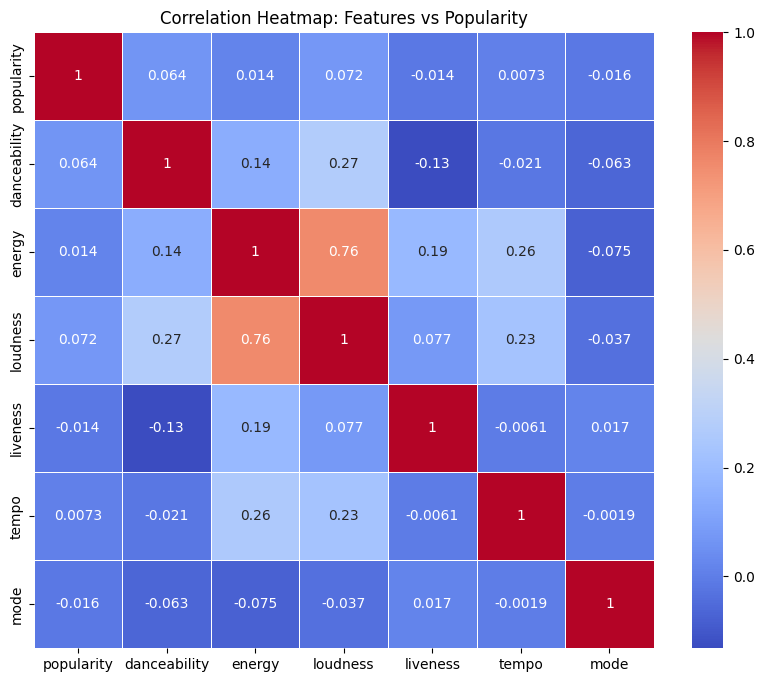

In [ ]:
# 2. Correlation Heatmap: Examine correlations between numerical features and popularity.
plt.figure(figsize=(10, 8))
correlation_matrix = df_cleaned[['popularity', 'danceability', 'energy', 'loudness', 'liveness', 'tempo', 'mode']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap: Features vs Popularity')
plt.show()

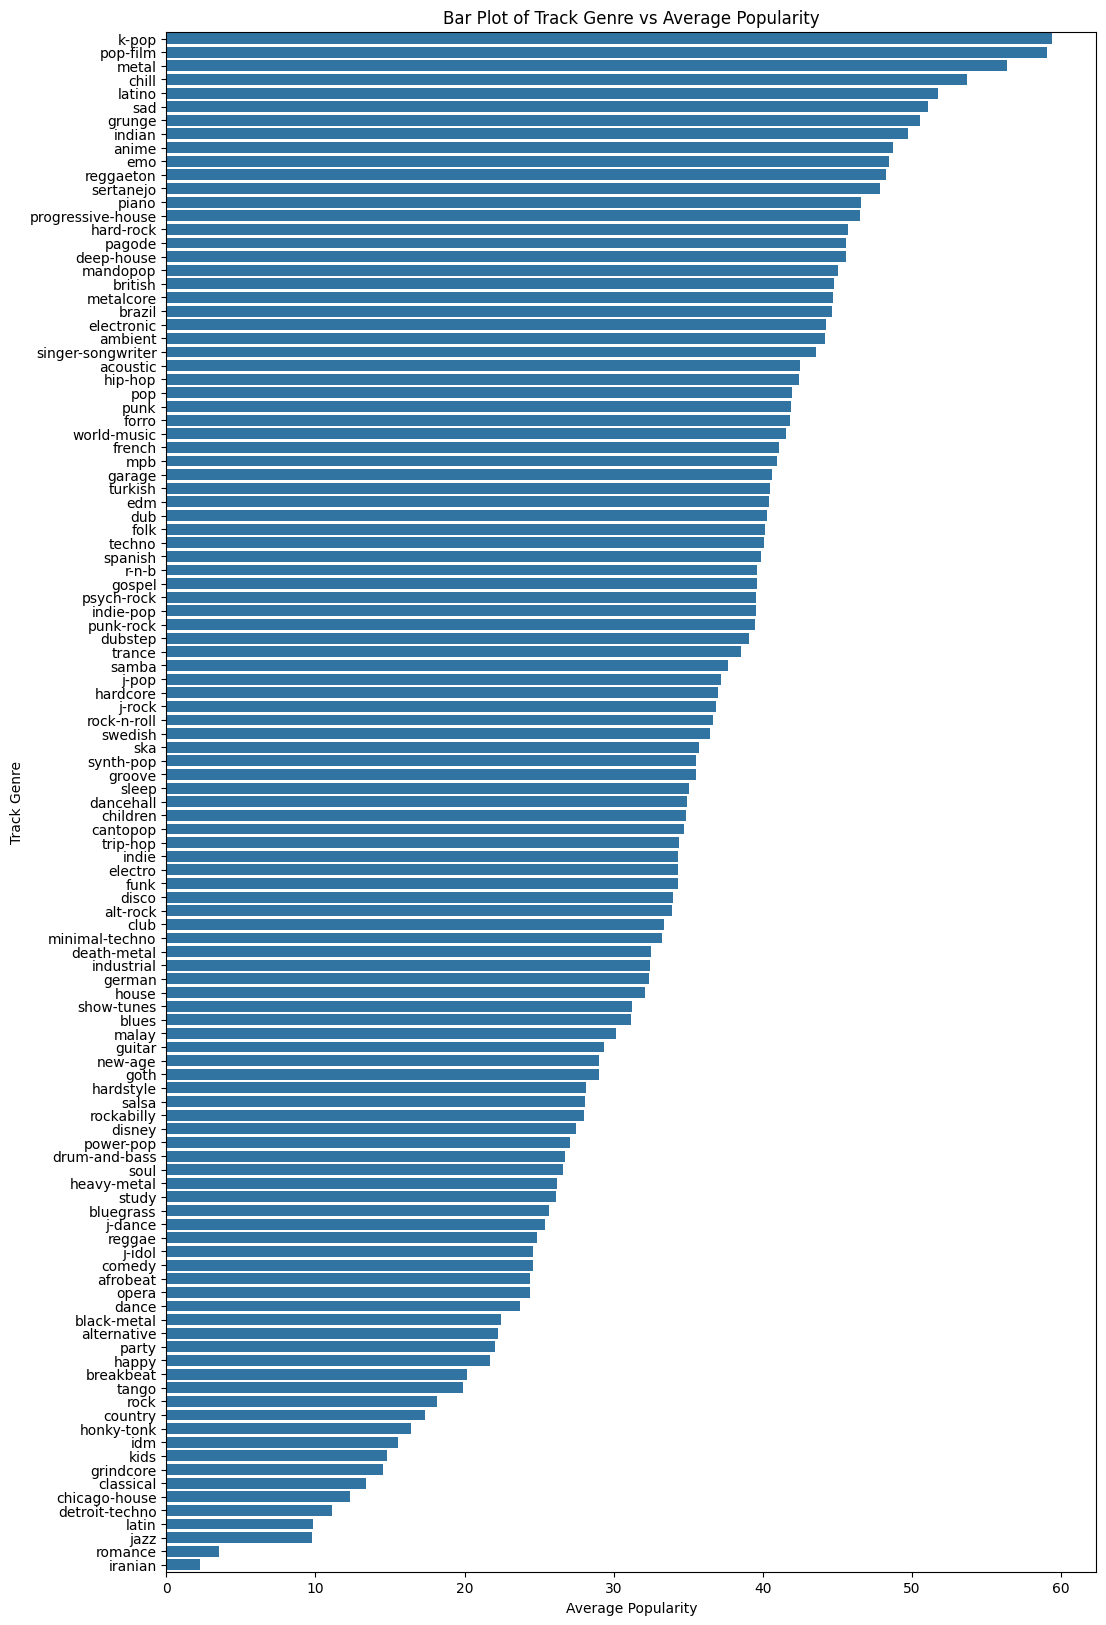

In [ ]:
# 3. Bar Plot: Compare the average popularity across different track genres.
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Group by track_genre and calculate their average popularity.
df_genre_popularity = df_cleaned.groupby('track_genre')['popularity'].mean().reset_index()

# Sort the genres by the average popularity in descending order.
df_genre_popularity = df_genre_popularity.sort_values(by='popularity', ascending=False)

# Set the figure size for better readability.
plt.figure(figsize=(12, 20))

# Create a bar plot to show the relationship between track_genre and average popularity.
sns.barplot(x='popularity', y='track_genre', data=df_genre_popularity)

# Add a title and labels.
plt.title('Bar Plot of Track Genre vs Average Popularity')
plt.xlabel('Average Popularity')
plt.ylabel('Track Genre')

# Show the plot.
plt.show()

# Week 2 - Regression
---

## Building our training, validation and testing data sets

There was only 1 dataset given in the Spotify dataset. So, we split the data into 60% for training, 20% for validation, and 20% for testing.

In [ ]:
# Training set takes 60% of the cleaned data.
spotify_train_processed = df_cleaned.sample(frac=0.6, random_state=42)
# Validation set takes half of what isn't in training set. This is 20% of the cleaned data.
spotify_val_processed = df_cleaned.drop(spotify_train_processed.index).sample(frac=0.5, random_state=42)
# Testing data is the other half of what is not in training set. This is the remaining 20% of the cleaned data.
spotify_test_processed = df_cleaned.drop(spotify_train_processed.index).drop(spotify_val_processed.index)

# Check the shape of each dataset.
print("Training set shape:", spotify_train_processed.shape)
print("Validation set shape:", spotify_val_processed.shape)
print("Testing set shape:", spotify_test_processed.shape)

# Check for data leakage.
combined_sets = pd.concat([spotify_train_processed, spotify_val_processed, spotify_test_processed])
duplicates = combined_sets.duplicated(subset=['track_id']).sum()
print("Number of duplicate rows accross training, validation, and set:", duplicates)

## Preparing to model our regression

To further our knowledge on regression, we built a mini-model where our response variable was **popluarity**.  

We selected 4 predictor variables using **forward selection**.

In [ ]:
# DEFINE FORWARD SELECTION ALGORITHM

# We chose 4 of the 11 numerical features as our predictor variables.
X = spotify_train_processed[['duration_ms','danceability','energy','key','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo']]
y = np.array(spotify_train_processed['popularity'])

# Initialize variables.
selected_features = []
best_mse = float('inf')
desired_num_features = 4

# Forward selection loop:
while len(selected_features) < desired_num_features:
    best_feature = None
    for feature in X.columns:
        if feature not in selected_features:
            candidate_features = selected_features + [feature]
            model = LinearRegression().fit(X[candidate_features], y)
            mse = mean_squared_error(y, model.predict(X[candidate_features]))
            if mse < best_mse:
                best_mse = mse
                best_feature = feature

    if best_feature:
        selected_features.append(best_feature)
        print(f"Selected feature: {best_feature}, MSE: {best_mse}")
    else:
        break

print(f"Final selected features: {selected_features}")

Selected feature: instrumentalness, MSE: 416.22615389362886
Selected feature: speechiness, MSE: 414.82059288050164
Selected feature: valence, MSE: 413.6591566807858
Selected feature: danceability, MSE: 410.8322042605641
Final selected features: ['instrumentalness', 'speechiness', 'valence', 'danceability']


In [ ]:
# Initialize the model.
# popularity predictor using linear regression

pop_lin_fit = LinearRegression()

# X_train = np.array(spotify_train_processed[selected_features]).reshape(-1, len(selected_features))
X_train = spotify_train_processed[selected_features].values
y_train = spotify_train_processed['popularity'].values

# Fit the model with multiple features (X) and target variable (y).
pop_lin_fit.fit(X=X_train,
            y=y_train)

# Display the intercept and coefficients.
print("Intercept:", pop_lin_fit.intercept_)
print("Coefficients:", pop_lin_fit.coef_)

Intercept: 33.3438336218878
Coefficients: [ -9.42560632 -12.09341623  -7.92479049  11.02989333]


In [ ]:
from mlxtend.evaluate import bias_variance_decomp

# Predictor variables from validation and training.
X_valid = spotify_val_processed[selected_features].values
X_test = spotify_test_processed[selected_features].values

# validation + testing actual popularity
y_valid = spotify_val_processed['popularity'].values
y_test = spotify_test_processed['popularity'].values

# validation + testing predicted popularity
y_valid_pred = pop_lin_fit.predict(X_valid)
y_test_pred = pop_lin_fit.predict(X_test)


avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        pop_lin_fit, X_train, y_train, X_valid, y_valid,
        loss='mse',
        random_seed=123)


print('Square root of Average expected loss: %.3f' % np.sqrt(avg_expected_loss))
print('Average bias: %.3f' % np.sqrt(avg_bias))
print('Average std: %.3f' % np.sqrt(avg_var))

Square root of Average expected loss: 20.340
Average bias: 20.339
Average std: 0.189


**Data Analysis**

By analyzing the bias and variance compared to the average expected loss, we noticed that our model strongly underfits the data. Most of the error is due to bias.

## Regularization of our model

In [ ]:
from sklearn.linear_model import  Ridge, Lasso
from sklearn.model_selection import cross_val_score, cross_validate

# use 10-fold cross-validation to select the best lambda (alpha) value for the ridge regression model

# define the alpha values to test
# note that the start/stop values in the first two arguments are the exponents
alphas = np.logspace(-1, 6, 100)

# create an empty list to store the cross-validation scores
ridge_cv_scores = []

# create a for loop to compute the cross-validation score for each alpha value
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge_cv = cross_validate(estimator=ridge,
                              X=X_std,
                              y=y,
                              cv=10,
                              scoring='neg_root_mean_squared_error')
    ridge_cv_scores.append({'alpha': alpha,
                            'log_alpha': np.log(alpha),
                            'test_mse': -np.mean(ridge_cv['test_score'])})

# convert the cross-validation scores into a data frame
ridge_cv_scores_df = pd.DataFrame(ridge_cv_scores)

# plot the cross-validation scores as a function of alpha
px.line(ridge_cv_scores_df,
        x='log_alpha',
        y='test_mse',
        title='Ridge')